# I need to do some interpolation

This notebook shows how you can use [Sherpa](https://sherpa.readthedocs.io/) to do some
simple interpolation after "fitting" your data. It is a fairly basic task but hopefully illustrates
some of the basic components of Sherpa.

As winter has finally arrived in New England$^*$, I've taken to making the kids porridge for breakfast.
However, as shown below, the tabulated values for the amount of oatmeal and water (as we add milk
to taste, rather than when cooking) don't cover every serving size. So far I have been 
winging it$^\dagger$, but
that seems rather un-scientific, so let's see what the power of science$^\ddagger$ can do for me.

$^*$ well, it had when I originally wrote the notebook

$^\dagger$ also known as piecewise linear interpolation

$^\ddagger$ well, really it's simple maths, but this doesn't sound so exciting

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2024-01-02 11:03'

In [2]:
# This will only work once Sherpa has been installed, which we haven't mentioned yet!
import sherpa
sherpa.__version__

'4.16.0'

I want to include some inline plots, so need matplotlib enabled for the notebook. NumPy is also useful
with Sherpa.

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Setting up Sherpa

For this notebook I am going to use CIAO 4.16 installed with conda (to match the
myBinder environment). You can use the standalone version of Sherpa with the
following:

```
% conda create -n sherpa-standalone-notebooks \
  -c https://cxc.cfa.harvard.edu/conda/ciao -c conda-forge \
  ciao pyciao sherpa ds9 ciao-contrib jupyterlab python=3.11
...
... a lot of text
...
#
# To activate this environment, use
#
#     $ conda activate sherpa-notebooks
#
# To deactivate an active environment, use
#
#     $ conda deactivate

% conda activate sherpa-standalone-notebooks
```

Note that this was all done before starting up the notebook, which can be done by cloning the repository:

    % git clone https://github.com/DougBurke/sherpa-standalone-notebooks
    % cd sherpa-standalone-notebooks
    % jupyter lab

and then selecting the "really simple fit" option on the web page this creates.

## What is the data?

Here's the tabulated values from the Oatmeal packaging:

<table>
 <thead>
 <tr><th>Servings</th><th>Oatmeal (cups)</th><th>Water (cups)</th></tr>
 </thead>
 <tbody>
 <tr><td>1</td><td>0.5</td><td>1</td></tr>
 <tr><td>1.5</td><td>0.75</td><td>1.5</td></tr>
 <tr><td>2</td><td>1</td><td>1.75</td></tr>
 <tr><td>4</td><td>2</td><td>3.25</td></tr>
 <tr><td>8</td><td>4</td><td>6</td></tr>
 <tr><td>17</td><td>8</td><td>16</td></tr>
 </tbody>
</table>

Leaving aside the insanity of the use of cups as a sensible unit for
cooking, which is a topic for another day, I want to calculate the amount
of Oatmeal ($y_1$) and water ($y_2$) for a given serving size of porridge ($x$).

This can be represented as three Python lists:

In [5]:
x = [1, 1.5, 2, 4, 8, 17]
y1 = [0.5, 0.75, 1, 2, 4, 8]
y2 = [1, 1.5, 1.75, 3.25, 6, 16]

I expect these to be close to linear, but what do they really look like? Let's
"load" them into Sherpa to find out. First I load up the main "UI" module for
Sherpa (I have no need for the more complex routines in `sherpa.astro.ui` so
can just use the `sherpa.ui` module):

In [6]:
from sherpa import ui

It is okay if you see some warning messages here, as Sherpa supports a number of optional
packages.

Now the data can be loaded into Sherpa. As there's two datasets - $(x, y_1)$ and $(x, y_2)$ - I am
going to use identifiers of `1` and `2` (and will be explicit in using these identifiers, even though
many of the Sherpa functions will default to an identifier of `1` when not given):

In [7]:
ui.load_arrays(1, x, y1)
ui.load_arrays(2, x, y2)

For this analysis I am going to ignore errors, which means use a least-square statistic when I fit, and
turn off the error bars in the data and residual plots$\dagger$:

----

$\dagger$ the `get_plot_prefs` call is new in CIAO 4.16. In previous versions of this notebook I used `get_data_plot_prefs` and was
not able to change the preferences for the residual plot.

In [8]:
ui.set_stat('leastsq')
ui.get_plot_prefs('data')['yerrorbars'] = False
ui.get_plot_prefs('resid')['yerrorbars'] = False

With these changes, I can display the data (the warning message can be ignored here, since we
do not care about errors):

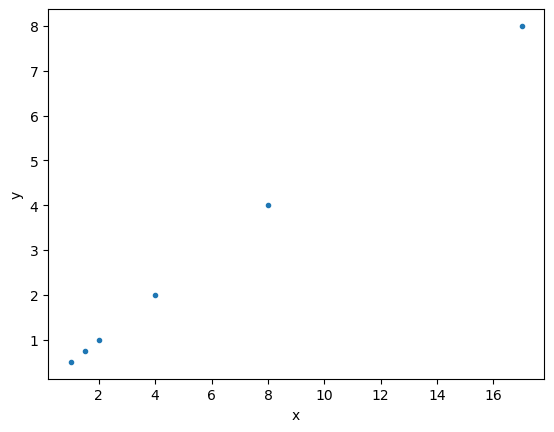

In [9]:
ui.plot_data(1)

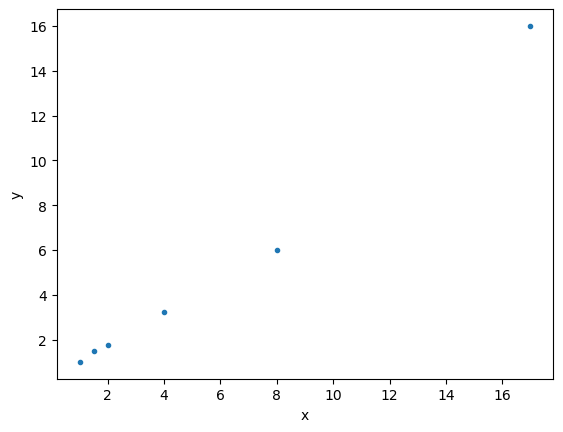

In [10]:
ui.plot_data(2)

So, they both look reasonably linear, although the second one less so. How do they compare?

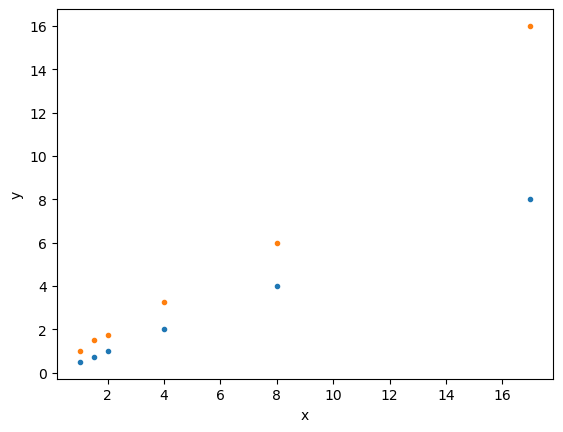

In [11]:
ui.plot_data(1)
ui.plot_data(2, overplot=True)

My guess, from looking at this plot, is that the first dataset (the blue points) can be modelled by a
staight line, whereas the second dataset (the green points) needs a quadratic.

Sherpa has a `polynom1d` model to handle low-order polynomials. I am going to
create an instance of this model and set it as the "source" model of the
first dataset - i.e. use it to describe the data:

In [12]:
ui.set_source(1, ui.polynom1d.m1)

This line did two things:

1. the statement `ui.polynom1d.m1` created an instance of the `polynom1d` model called `m1`
2. the `ui.set_source` call set this as the model to be fit to the first dataset (much more
   complicated expressions can be used, but for this notebook a single component is all that
   is needed).

The `m1` component has a number of parameters, which can be displayed with a call to `print`
or, as of the 4.12.2 release of Shera,you can display them directly in the Jupyter notebook:

In [13]:
print(m1)

polynom1d.m1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   m1.c0        thawed            1 -3.40282e+38  3.40282e+38           
   m1.c1        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c2        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c3        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c4        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c5        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c6        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c7        frozen            0 -3.40282e+38  3.40282e+38           
   m1.c8        frozen            0 -3.40282e+38  3.40282e+38           
   m1.offset    frozen            0 -3.40282e+38  3.40282e+38           


In [14]:
m1

<Polynom1D model instance 'polynom1d.m1'>

Parameters - e.g. `m1.c0` and `m1.c1` - control the model values, and their meaning depends
on the model (in this case `polynom1d`). The model documentation - e.g. `help(m1)` - provides
information on the model and its parameters, but this **must** be done on a model "instance",
since using the model class (i.e. `ui.polynom1d`) does not provide anything useful.


I am not going to include the help here, as it is quite long (since it also includes some standard Python documentation for classes), but it does tell me that the `polynom1d` model is defined as (assuming that $\rm{offset} \equiv 0$):

$$y = \sum_{i=0}^8 c_i x^i$$

so `c0` is the intercept term and `c1` the slope for a straight line.

The `type` column - which is either `frozen` or `thawed` (which seems quite apt as earlier today
I was out shovelling snow) - indicates whether the parameter can be varied during a fit. In this
case the model starts out with only the intercept term being free to be fit.

With these parameter settings, the model evaluates to `1` for each point. The model can be
displayed with a call to `ui.plot_model`, but that's not going to be particularly illuminating.
It's a bit more interesting to compare the model to the data:

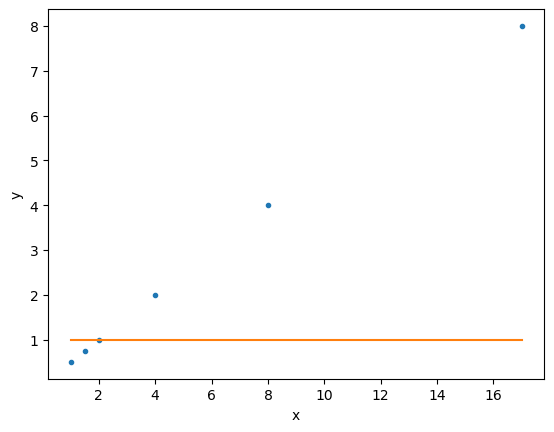

In [15]:
ui.plot_fit(1)

The parameters can be modified manually, such as adding a linear component to the model:

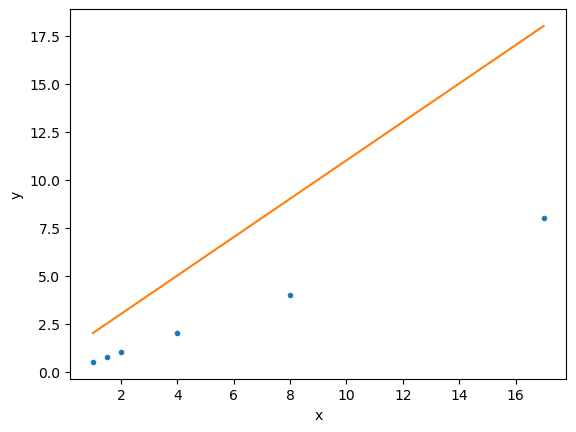

In [16]:
m1.c1 = 1
ui.plot_fit(1)

However, the whole point of using Sherpa is to get it to do the fit!

In [17]:
ui.fit(1)

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 143.312
Final fit statistic   = 53.2188 at function evaluation 4
Data points           = 6
Degrees of freedom    = 5
Change in statistic   = 90.0937
   m1.c0          -2.875       +/- 0.408248    


The optimiser - in this case, one based on the Levenberg-Marquardt algorithm from 
[MINPACK](https://people.sc.fsu.edu/~jburkardt/f_src/minpack/minpack.html), although in this
case most optimisers should work - has found the best-fit solution by minimising the
least-squares distance between the data and model:

$$\sum_i (y_i - \rm{model}_i)^2$$

Hopefully it's a better fit; let's check:

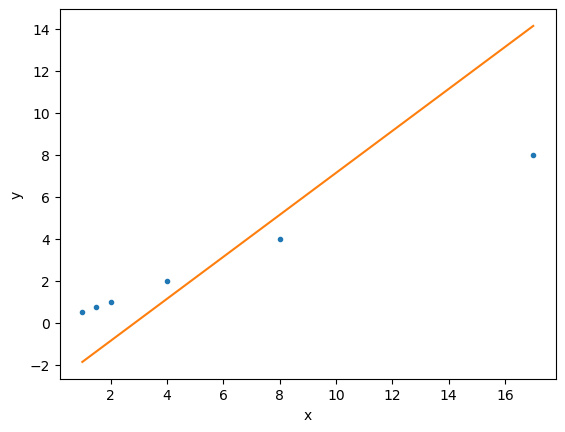

In [18]:
ui.plot_fit(1)

Oops, the only parameter fit was the intercept (`m1.c0`) because I had forgotten to "thaw" the slope parameter. This can actually be seen in the output of the `fit` command earlier, since:

* only the `m1.c0` parameter value was displayed
* the "`Degrees of Freedom`" was given as 5, and as there are only 6 data points this means that only one
  parameter was fit.
   
Rectifying this mistake gives a better fit (both visually, and numerically since the fit statistic has
changed from $\sim 53$ to $\sim 0.04$):

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 53.2188
Final fit statistic   = 0.0361154 at function evaluation 6
Data points           = 6
Degrees of freedom    = 4
Change in statistic   = 53.1826
   m1.c0          0.0851134    +/- 0.575695    
   m1.c1          0.46983      +/- 0.0726992   


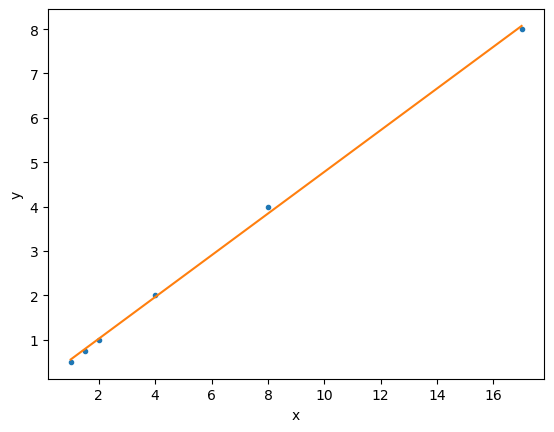

In [19]:
ui.thaw(m1.c1)
ui.fit(1)
ui.plot_fit(1)

The residuals - defined as `data - model` - can be displayed using `ui.plot_resid`:

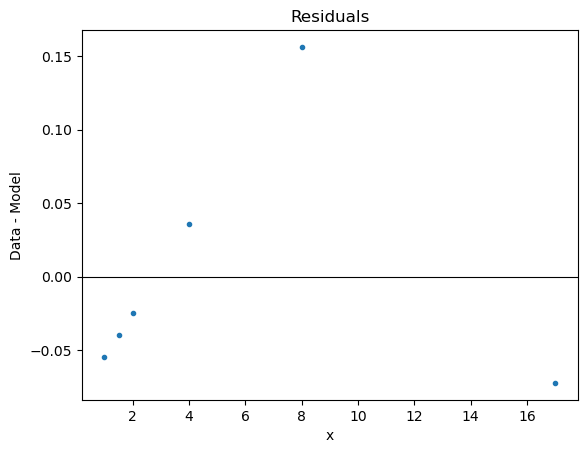

In [20]:
ui.plot_resid(1)

So, over this range, a linear model is only out by at most $\sim 0.2$.

Let's see how well a linear model does with the second dataset (the `ui.plot_fit_resid` call creates two plots; the top one the `fit` plot and the bottom one the `resid` one):

Dataset               = 2
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 255.875
Final fit statistic   = 1.89763 at function evaluation 6
Data points           = 6
Degrees of freedom    = 4
Change in statistic   = 253.977
   m2.c0          -0.248624    +/- 0.575695    
   m2.c1          0.925127     +/- 0.0726992   


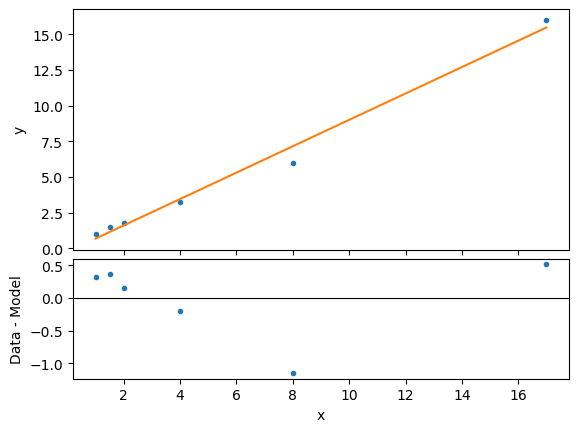

In [21]:
ui.set_source(2, ui.polynom1d.m2)
# I could have said ui.thaw(m2.c1), but the parameter attributes can also be changed directly
m2.c1.frozen = False
ui.fit(2)
ui.plot_fit_resid(2)

So, the residuals look a little bigger here, about $\sim 1$. Let's check, this time calculating the residuals rather than using `ui.get_resid_plot`:

In [22]:
resid2 = np.asarray(y2) - m2(x)

The model - in this case `m2` - when given an array will return an array of values of the model evaluated at
these points. I used this to create the `resid2` array, which has a minimum and maximum of:

In [23]:
resid2.min()

-1.1523893415533468

In [24]:
resid2.max()

0.5214710416238386

An obvious question is does a quadratic model give a better approximation than the linear model for this data set? To make it easy to compare, I add a third dataset, and fit a quadratic model to it:

Dataset               = 3
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 255.875
Final fit statistic   = 0.108069 at function evaluation 8
Data points           = 6
Degrees of freedom    = 3
Change in statistic   = 255.767
   m3.c0          0.64415      +/- 0.881369    
   m3.c1          0.498841     +/- 0.326848    
   m3.c2          0.0237181    +/- 0.0177299   


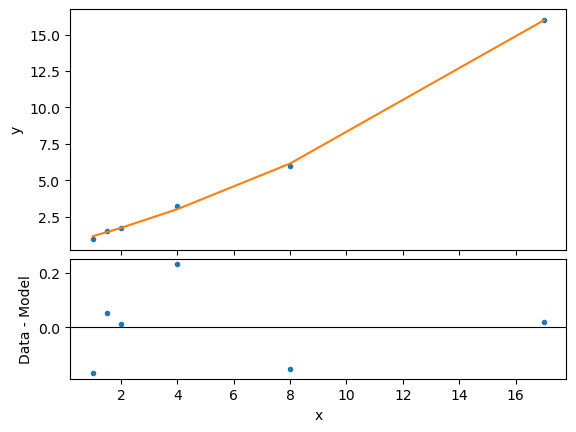

In [25]:
ui.load_arrays(3, x, y2)
ui.set_source(3, ui.polynom1d.m3)
ui.thaw(m3.c0, m3.c1, m3.c2)  # thaw can be applied to multiple parameters
ui.fit(3)
ui.plot_fit_resid(3)

As expected, the residuals are smaller, but how do the models compare visually?

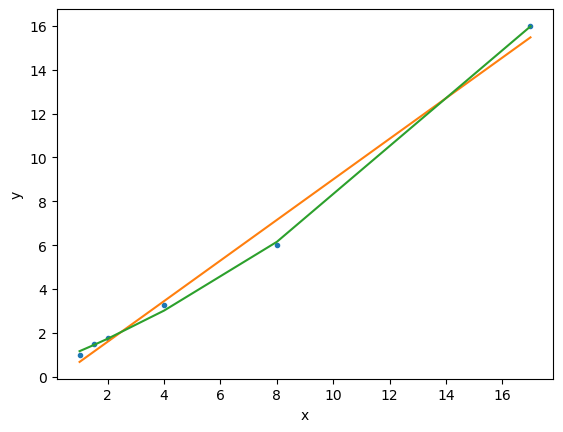

In [26]:
ui.plot_data(2)
ui.plot_source(2, overplot=True)
ui.plot_source(3, overplot=True)

I could add extra terms to the polynomial, or a different model, but I think that we have what we need.
I can wrap the models up in a simple function to display the interpolated (i.e. model) values for a given
number of servings by calling the models with a single-element array. The only slightly-tricky thing to
remember is to make sure the input array has a floating-point type, otherwise the output will be in
integer format.

In [27]:
def ingredients(nservings):
    """How much oatmeal and water do I need?
    
    Parameters
    ----------
    nservings: int
        The number of servings
        
    Returns
    -------
    (oatmeal, water_lin, water_quad)
        The number of cups of oatmeal and water. The water values are
        calculated using a linear and quadratic approximation respectively.
    """
    
    x = [nservings * 1.0]
    oats = m1(x)[0]
    water_l = m2(x)[0]
    water_q = m3(x)[0]
    return {'oats': oats, 'water (linear)': water_l, 'water (quadratic)': water_q}

With this, I can now happily cook breakfast for the kids! The only decision - other than how many dried cranberries
to add to the mix - is whether to use the linear or quadratic version!

In [28]:
ingredients(1)

{'oats': 0.5549438449680721,
 'water (linear)': 0.6765029729133807,
 'water (quadratic)': 1.1667091967194232}

In [29]:
ingredients(3)

{'oats': 1.4946047126187016,
 'water (linear)': 2.526756221096228,
 'water (quadratic)': 2.354135374844933}

In [30]:
ingredients(4)

{'oats': 1.9644351464440164,
 'water (linear)': 3.4518828451876518,
 'water (quadratic)': 3.0190027563625113}

# NO WARRANTY IS PROVIDED OR IMPLIED

Please note that no warrant is provided with this work. I take no responsibilty if using these
values leads to an inedible breakfast situation. Or a porridge explosion.